In [2]:
from functools import partial

import torch
from matplotlib import pyplot as plt

In [6]:
%load_ext autoreload
%autoreload 2

import numpy as np
import torch

torch.set_printoptions(linewidth=400, threshold=100000)

import sys

sys.path.append("../..")

from mlstm_kernels.components.ln import MultiHeadLayerNorm
from mlstm_kernels.mlstm.chunkwise.max_triton_fwbw_v3 import (
    mlstm_chunkwise_max_triton_v3,
)

import torch.nn.functional as F
from mlstm_cells import (
    mlstm_chunkwise_triton_kernel,
    mlstm_paper_stable_fgate,
    mlstm_paper_unstable_fgate,
    mlstm_stable_fgate_gla,
)
from sigprop_plots import make_offset_sweep_meshplot, make_offset_sweep_meshplot_grid

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Exponential Input Gate: vecI + vecF offset plots

### bfloat16 - debug plots

In [ ]:
# abs max

S = 2048
DQK = 64  # 1024
DV = 64  # 1024
DEVICE = torch.device("cuda")
DTYPE = torch.bfloat16
vecI_offset_range = torch.linspace(-12, 6, 50)
vecF_offset_range = torch.linspace(-5, 12, 50)
levels_before_ln = np.linspace(0, 5, 30)
levels_after_ln = np.linspace(0, 2, 30)
in_stds = [1.0]  # [0.25, 0.5, 1.0]
ln_epss = [1e-1, 1e-3, 1e-5, 1e-8]  # , 1e-10]
norm_type = "rms"
denom_const_vals = [10, 2048]
figs = []
for std in in_stds:
    fig = make_offset_sweep_meshplot_grid(
        mlstm_func=mlstm_paper_unstable_fgate,
        seq_len=S,
        dqk=DQK,
        dv=DV,
        device=DEVICE,
        dtype=DTYPE,
        vecI_offset_range=vecI_offset_range,
        vecF_offset_range=vecF_offset_range,
        q_std=std,
        k_std=std,
        v_std=std,
        levels_before_ln=levels_before_ln,
        levels_after_ln=levels_after_ln,
        norm_eps=ln_epss,
        denom_const_vals=denom_const_vals,
        metric="h_out_abs_max_mean-v_gain",
        norm_type=norm_type,
    )
    figs.append(fig)

In [ ]:
S = 2048
DQK = 64  # 1024
DV = 64  # 1024
DEVICE = torch.device("cuda")
DTYPE = torch.bfloat16
vecI_offset_range = torch.linspace(-12, 6, 50)
vecF_offset_range = torch.linspace(-5, 12, 50)
levels_before_ln = np.linspace(0, 5, 30)
levels_after_ln = np.linspace(0, 2, 30)
in_stds = [1.0, 0.6, 0.2]  # [0.25, 0.5, 1.0]
ln_epss = [1e-1, 1e-3, 1e-5, 1e-8]  # , 1e-10]
norm_type = "rms"
denom_const_vals = [10, 2048]
figs = []
for std in in_stds:
    print(f"in_std: {std}")
    fig = make_offset_sweep_meshplot_grid(
        mlstm_func=partial(mlstm_paper_unstable_fgate, eps=0.0),
        seq_len=S,
        dqk=DQK,
        dv=DV,
        device=DEVICE,
        dtype=DTYPE,
        vecI_offset_range=vecI_offset_range,
        vecF_offset_range=vecF_offset_range,
        q_std=std,
        k_std=std,
        v_std=std,
        levels_before_ln=levels_before_ln,
        levels_after_ln=levels_after_ln,
        norm_eps=ln_epss,
        denom_const_vals=denom_const_vals,
        metric="h_out_max_mean-v_gain",
        norm_type=norm_type,
    )
    figs.append(fig)

### Final Plots bfloat16

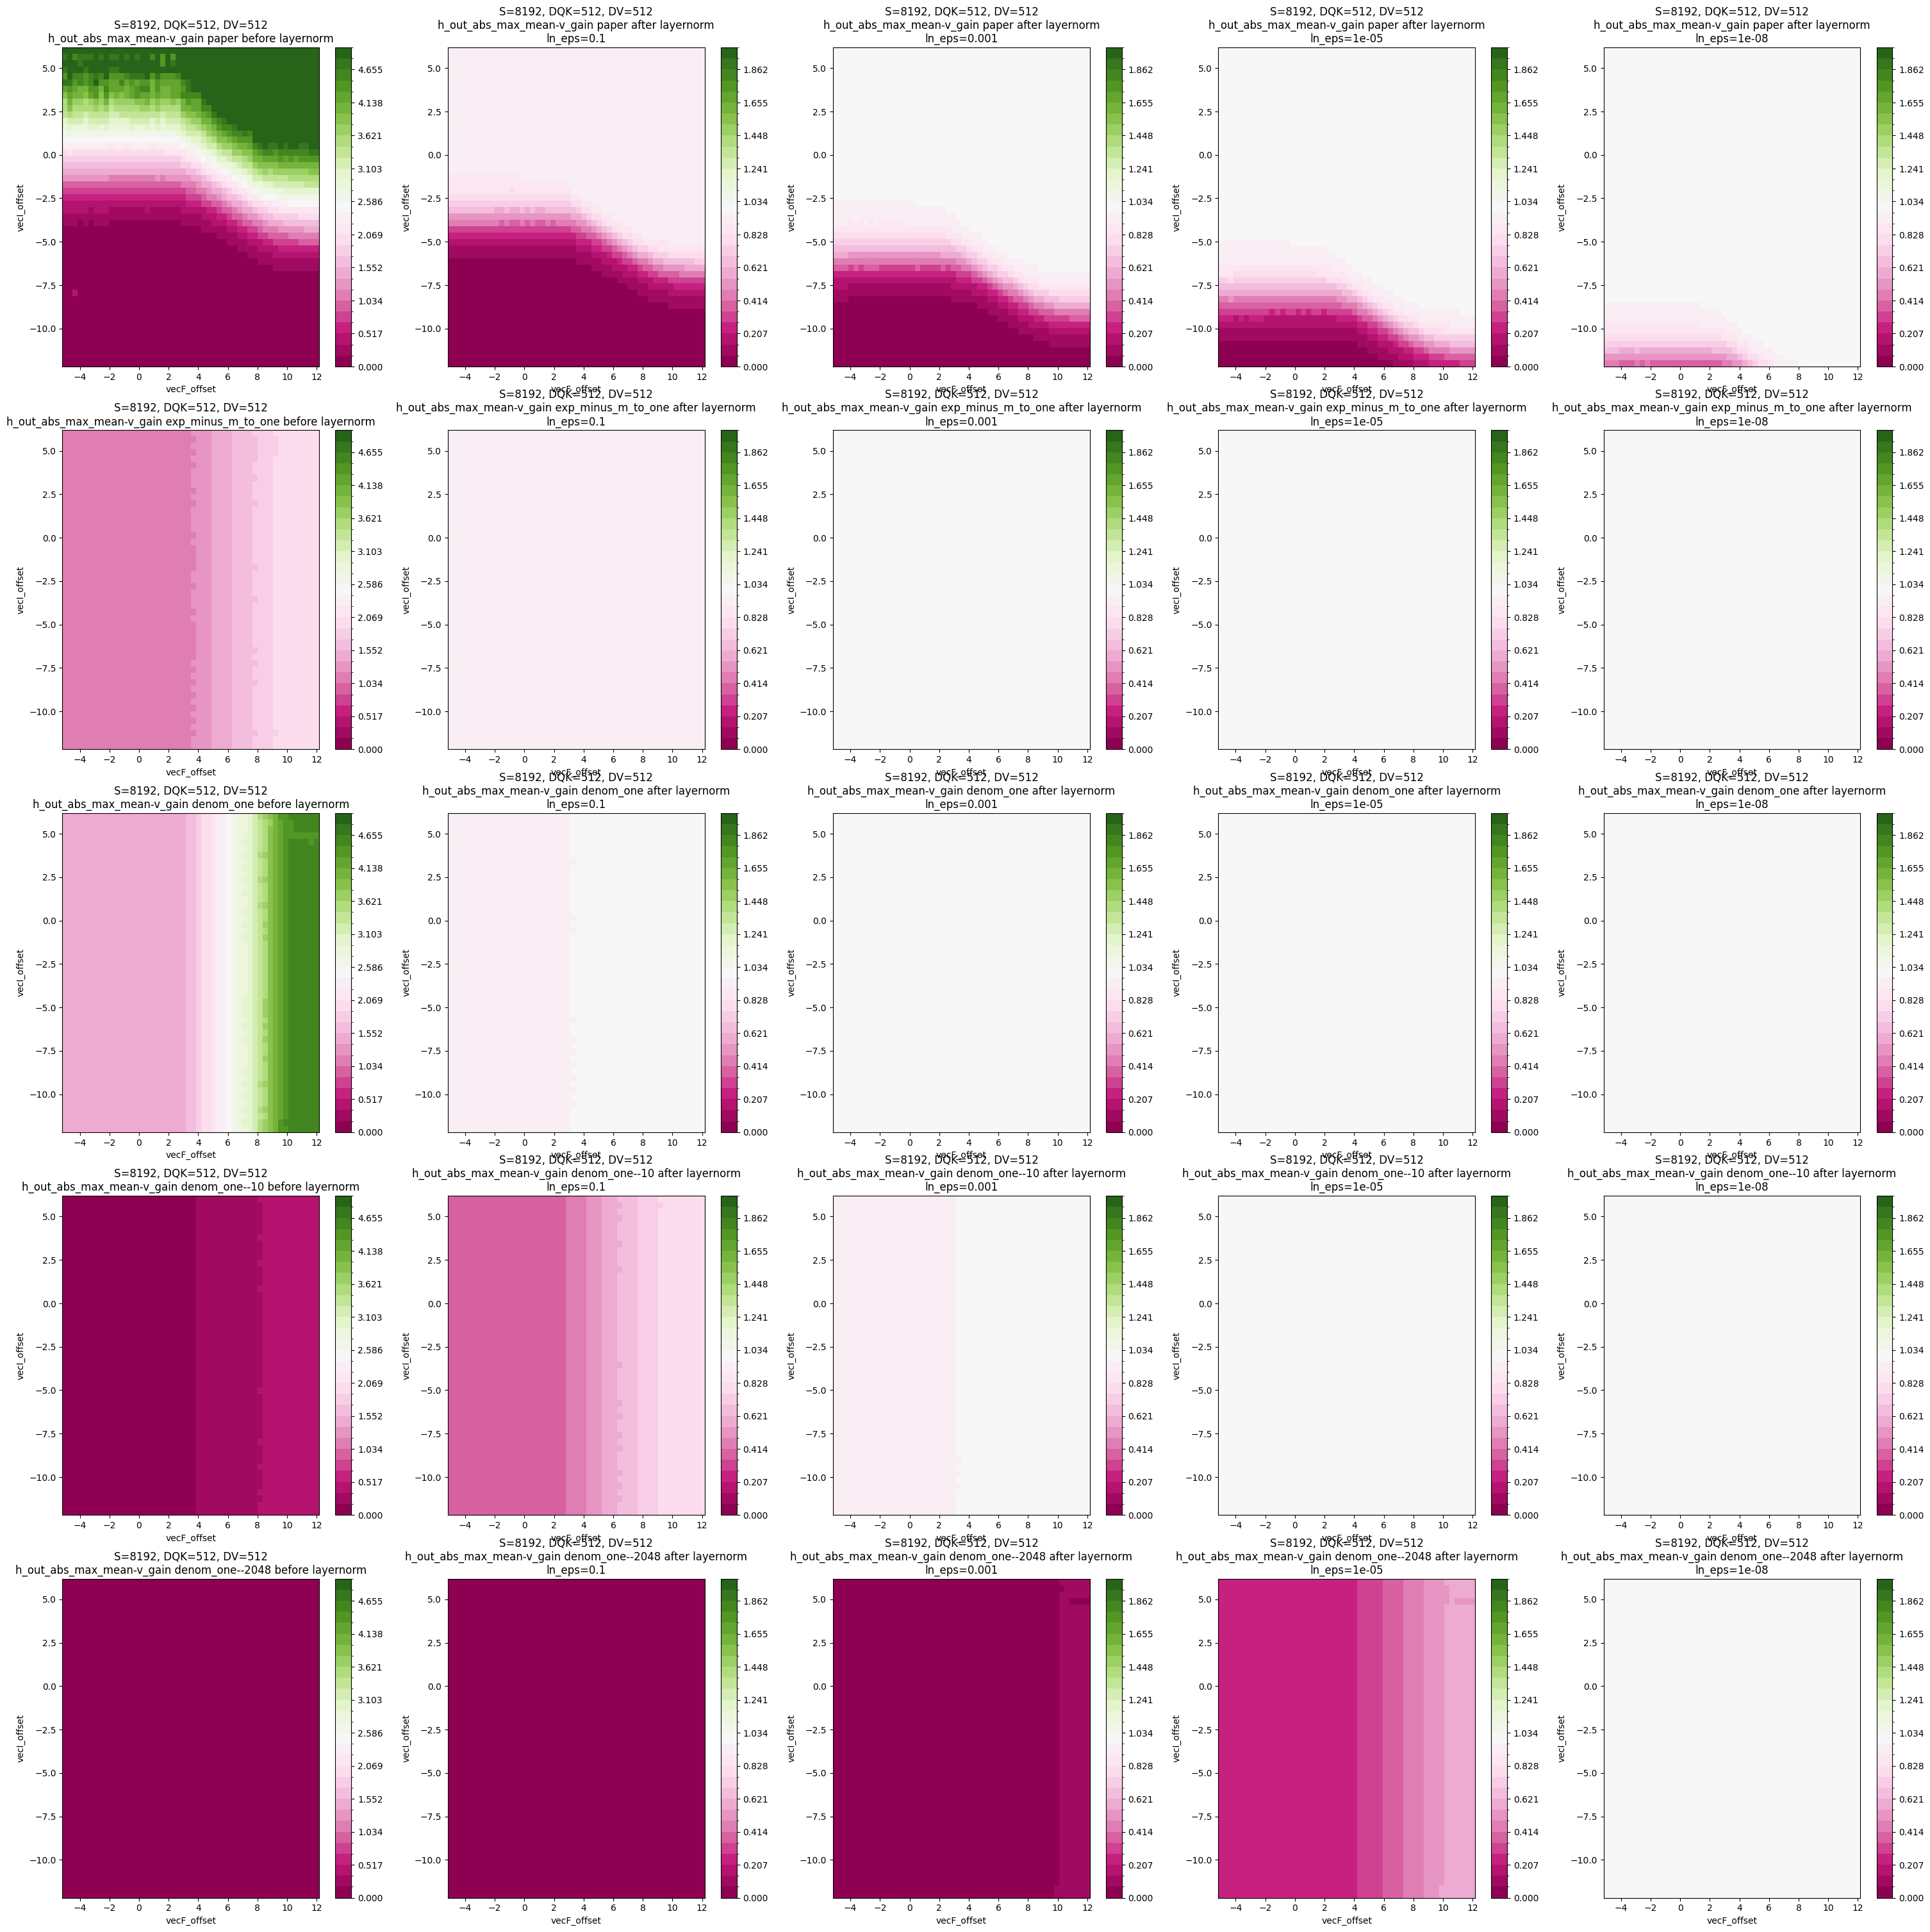

In [4]:
# abs max

S = 8192
DQK = 512  # 1024
DV = 512  # 1024
DEVICE = torch.device("cuda")
DTYPE = torch.bfloat16
vecI_offset_range = torch.linspace(-12, 6, 50)
vecF_offset_range = torch.linspace(-5, 12, 50)
levels_before_ln = np.linspace(0, 5, 30)
levels_after_ln = np.linspace(0, 2, 30)
in_stds = [1.0]  # [0.25, 0.5, 1.0]
ln_epss = [1e-1, 1e-3, 1e-5, 1e-8]  # , 1e-10]
norm_type = "rms"
denom_const_vals = [10, 2048]
figs = []
for std in in_stds:
    fig = make_offset_sweep_meshplot_grid(
        mlstm_func=mlstm_paper_unstable_fgate,
        seq_len=S,
        dqk=DQK,
        dv=DV,
        device=DEVICE,
        dtype=DTYPE,
        vecI_offset_range=vecI_offset_range,
        vecF_offset_range=vecF_offset_range,
        q_std=std,
        k_std=std,
        v_std=std,
        levels_before_ln=levels_before_ln,
        levels_after_ln=levels_after_ln,
        norm_eps=ln_epss,
        denom_const_vals=denom_const_vals,
        metric="h_out_abs_max_mean-v_gain",
        norm_type=norm_type,
    )
    figs.append(fig)

### GLA forget gate 

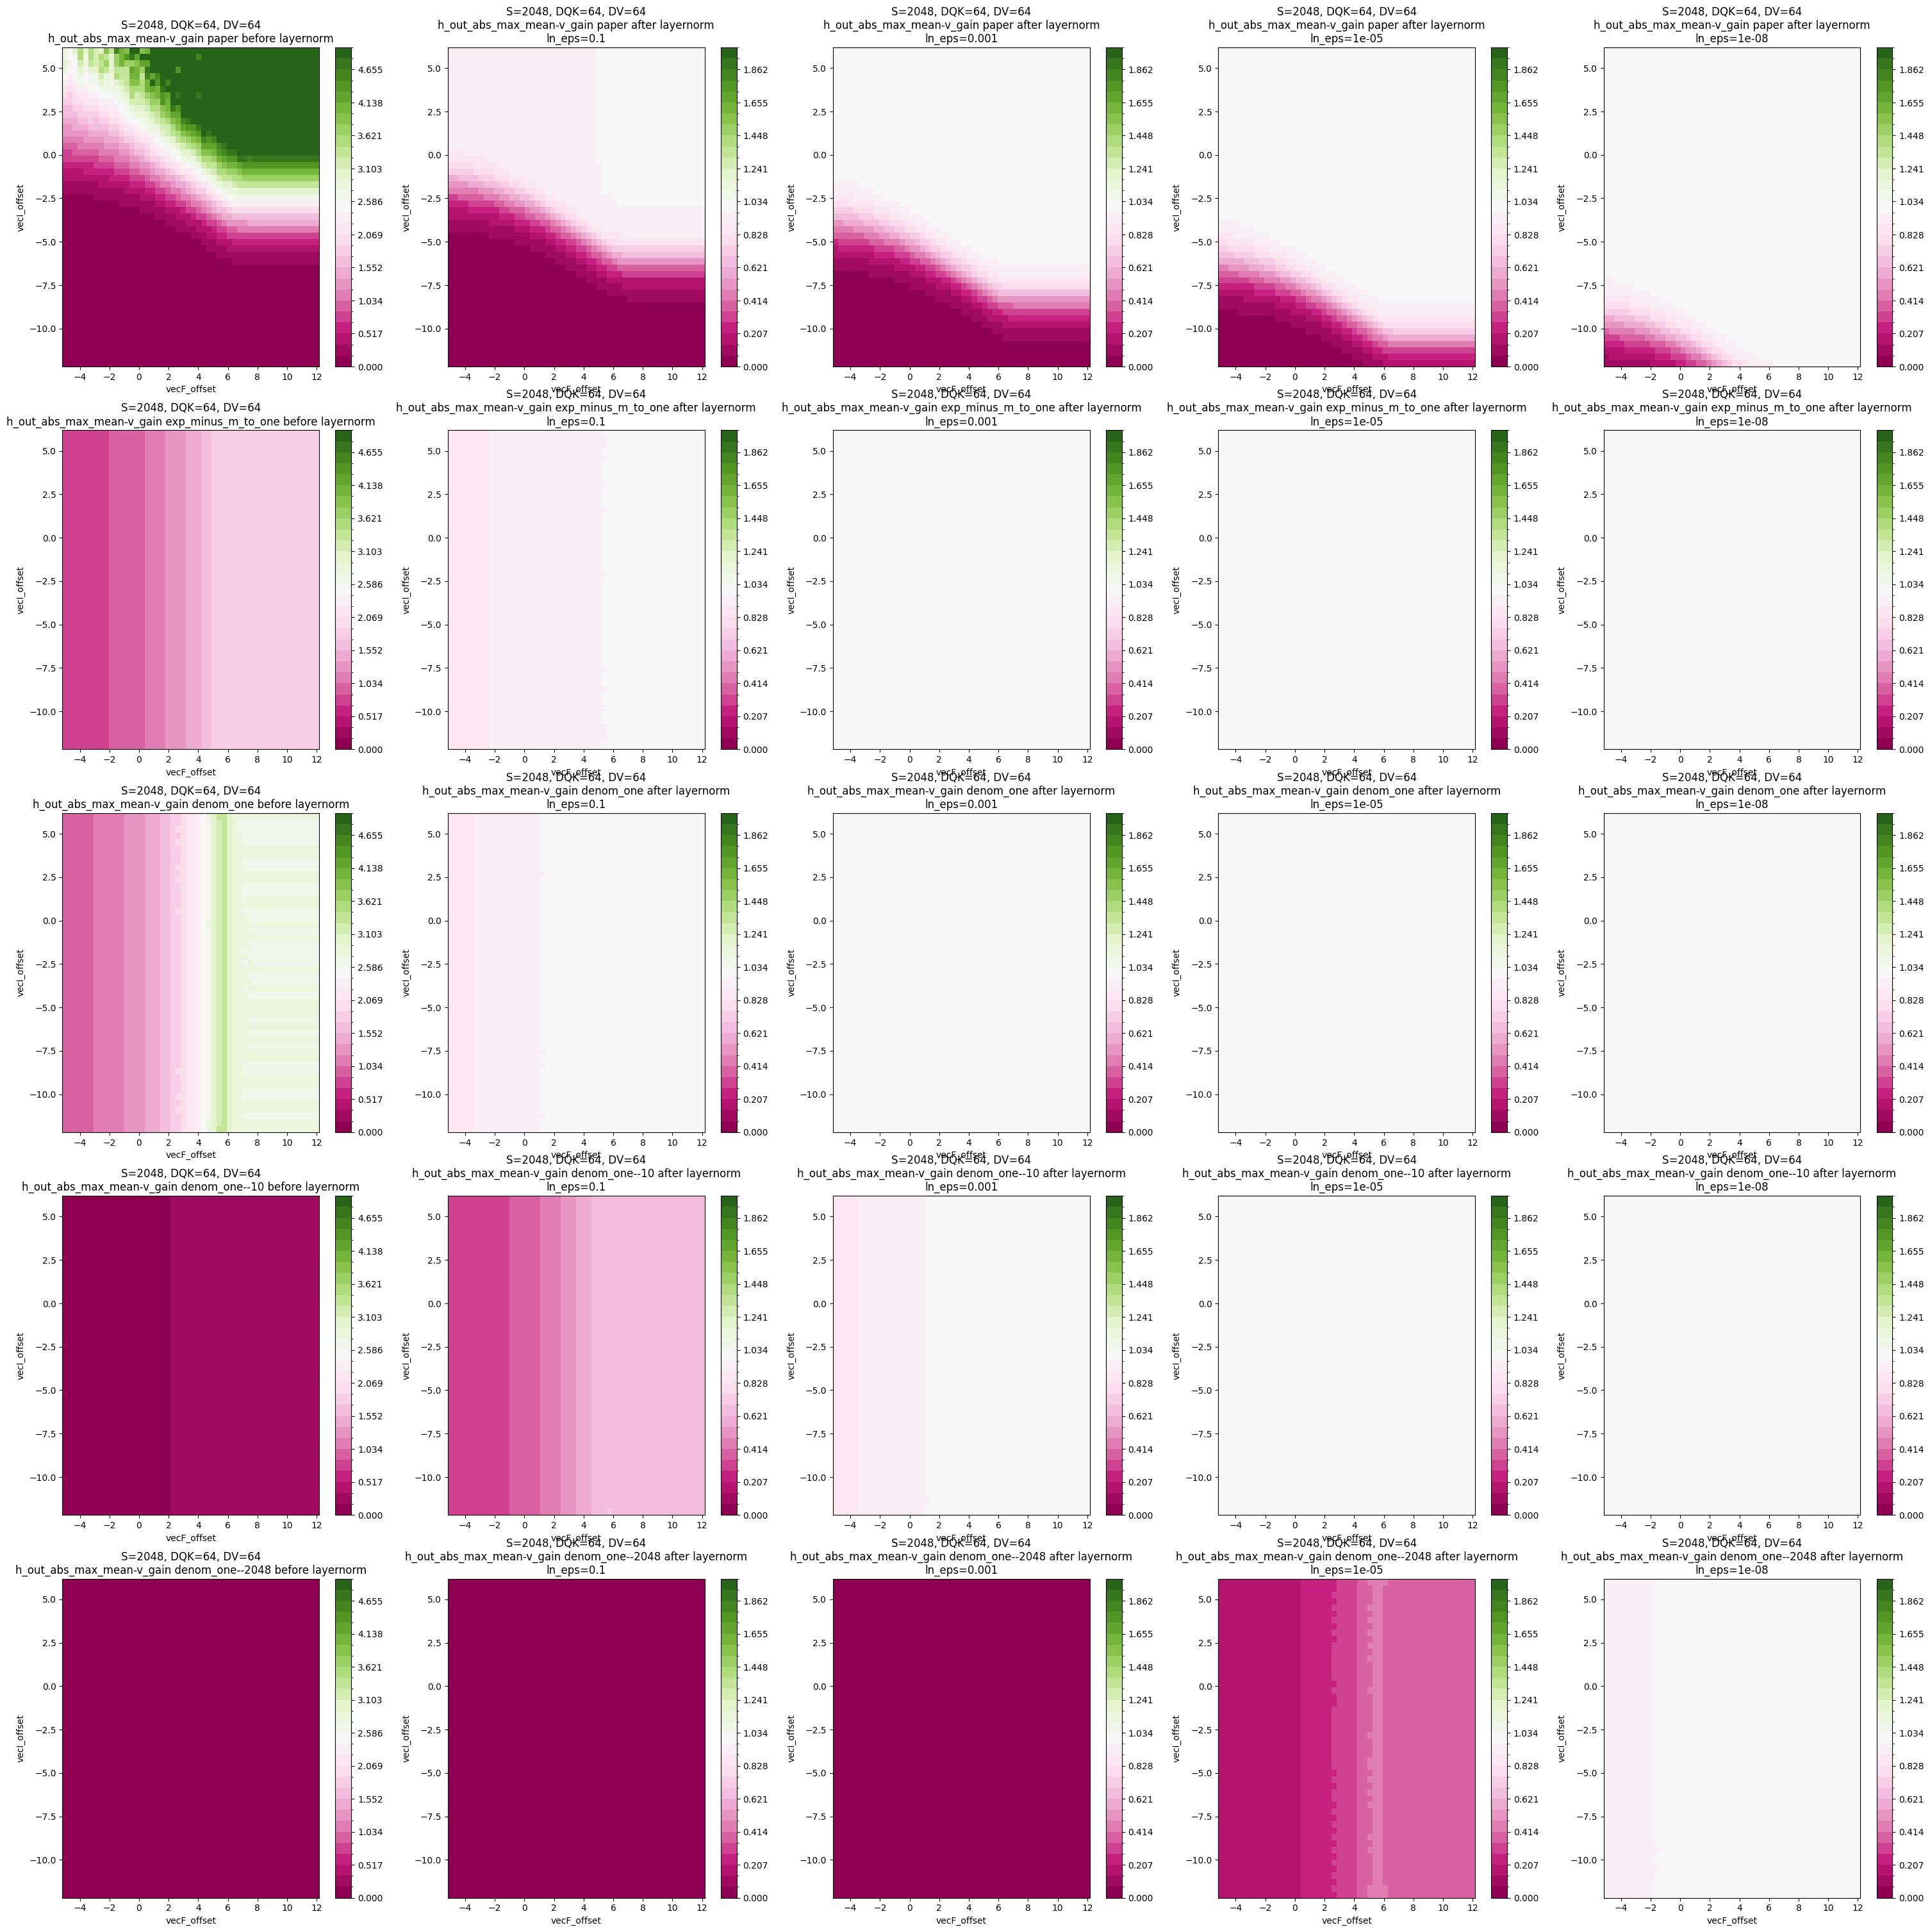

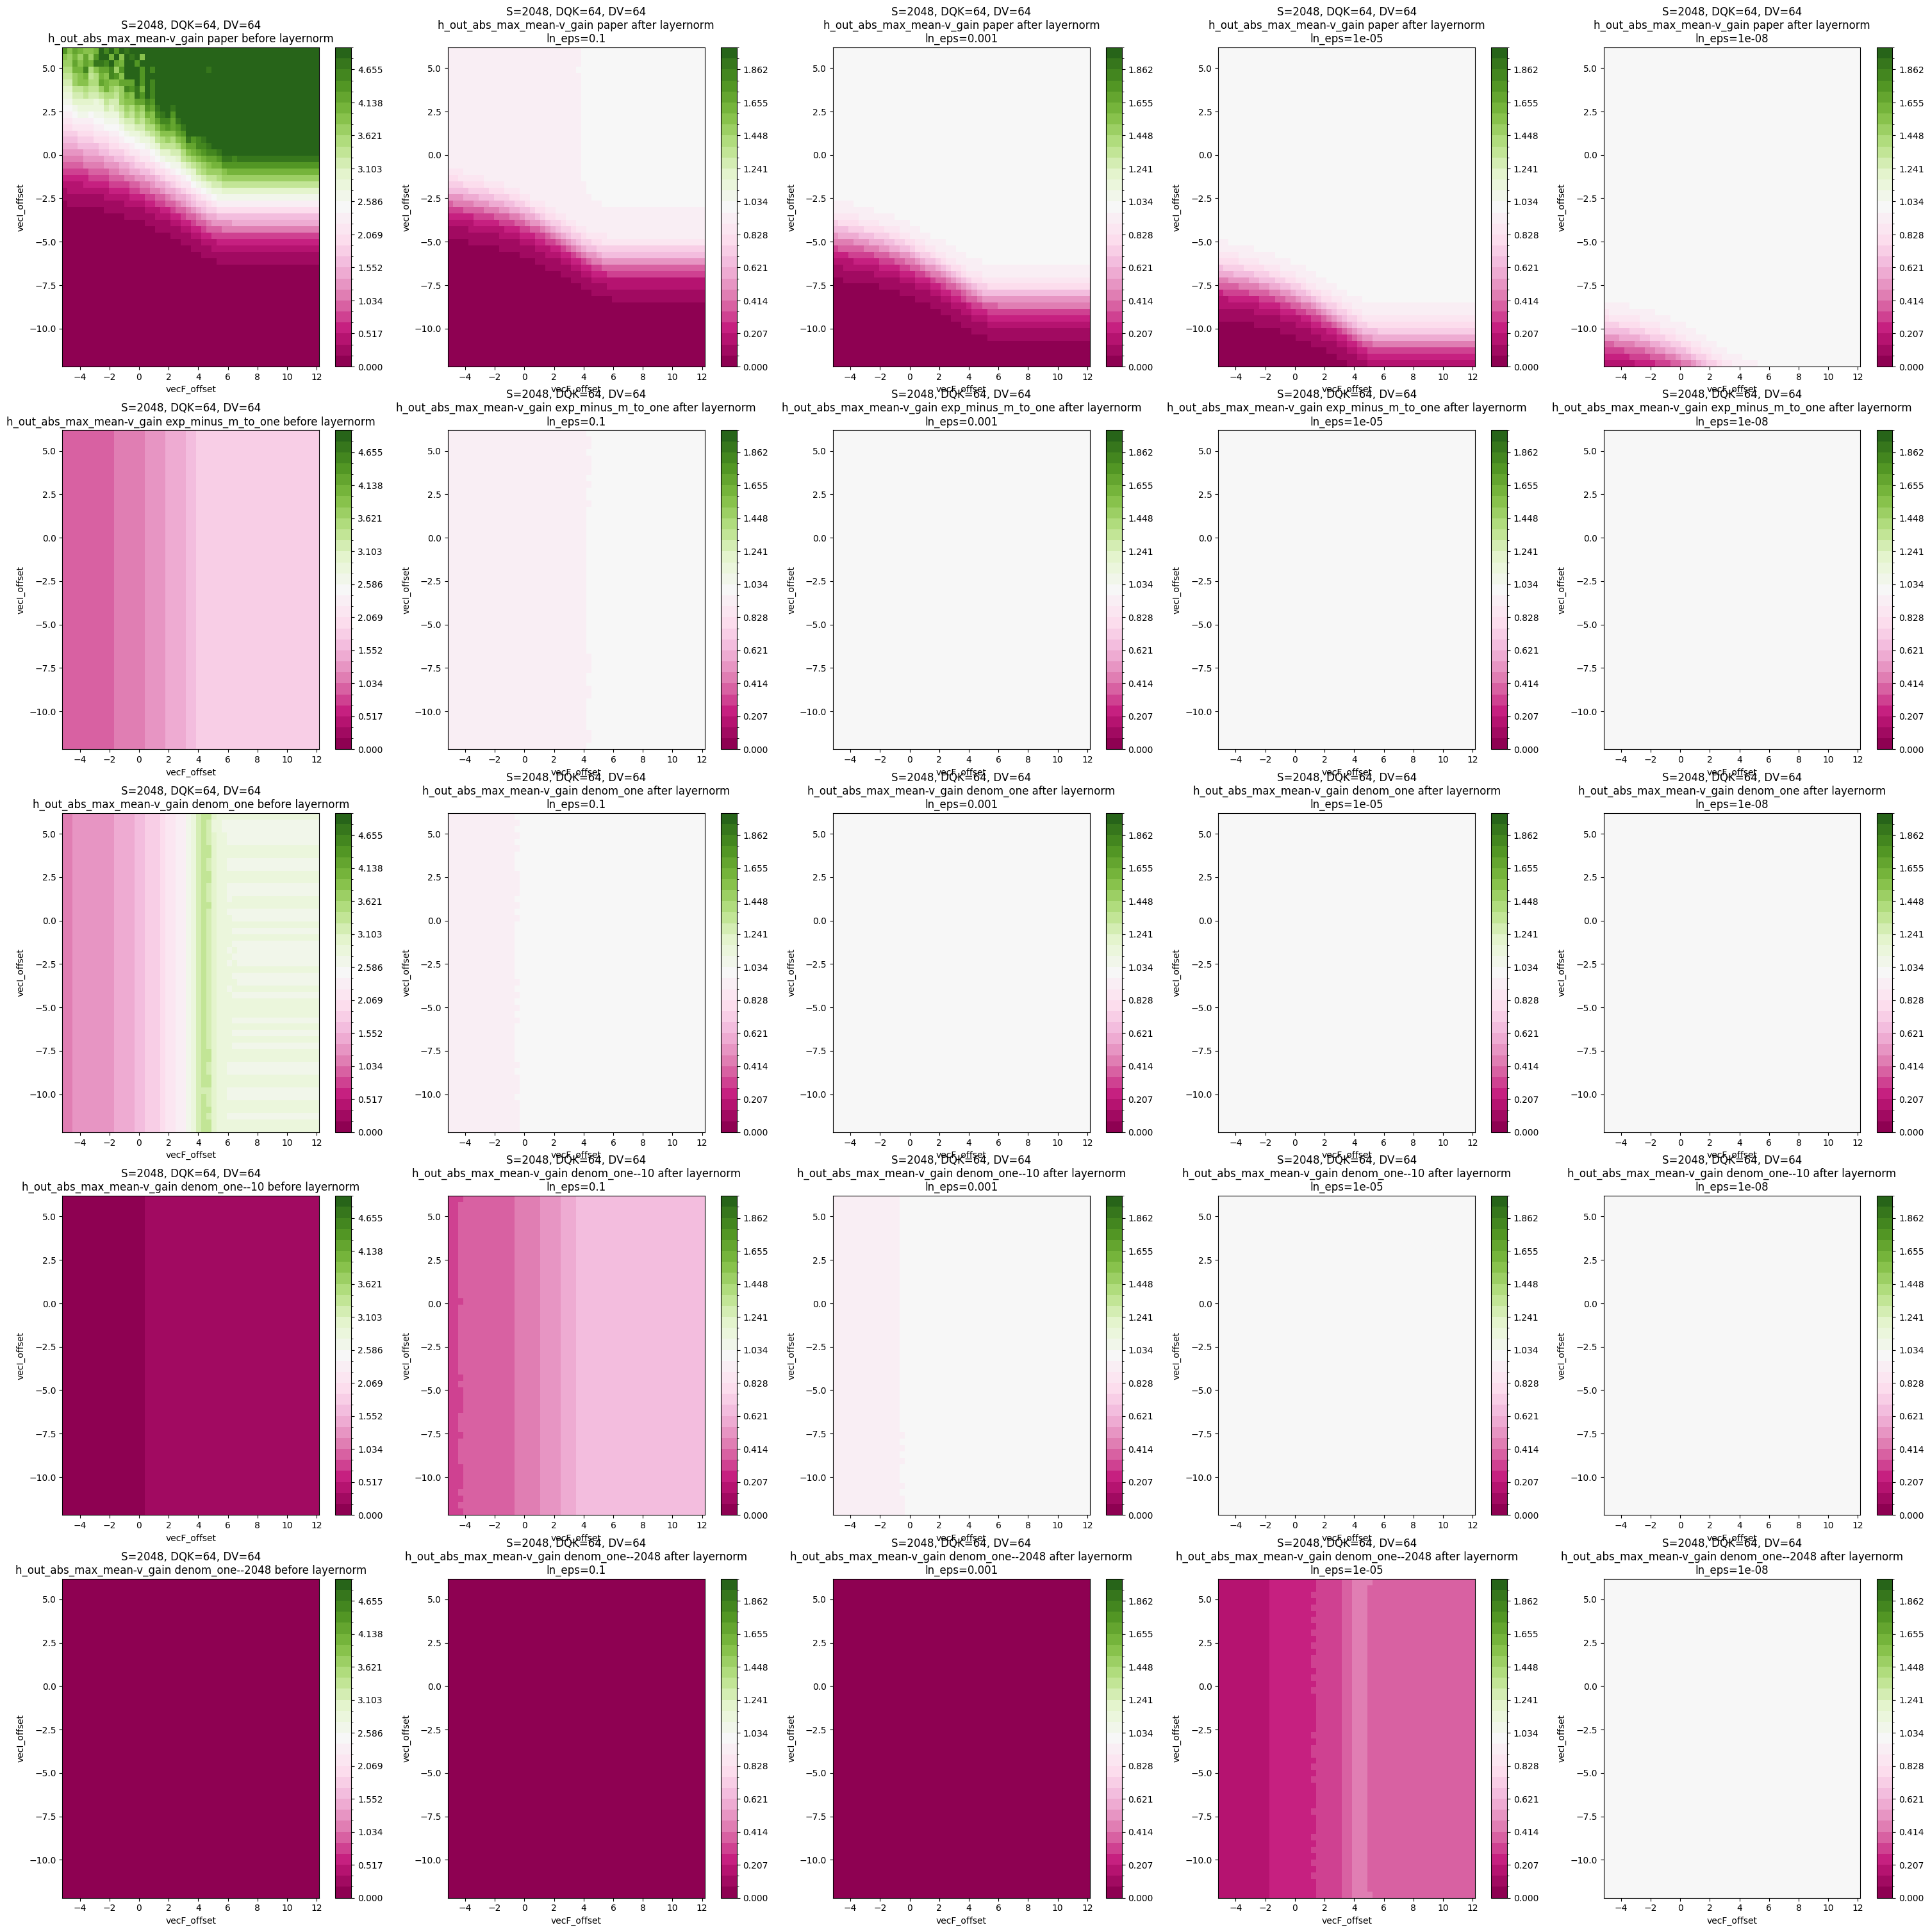

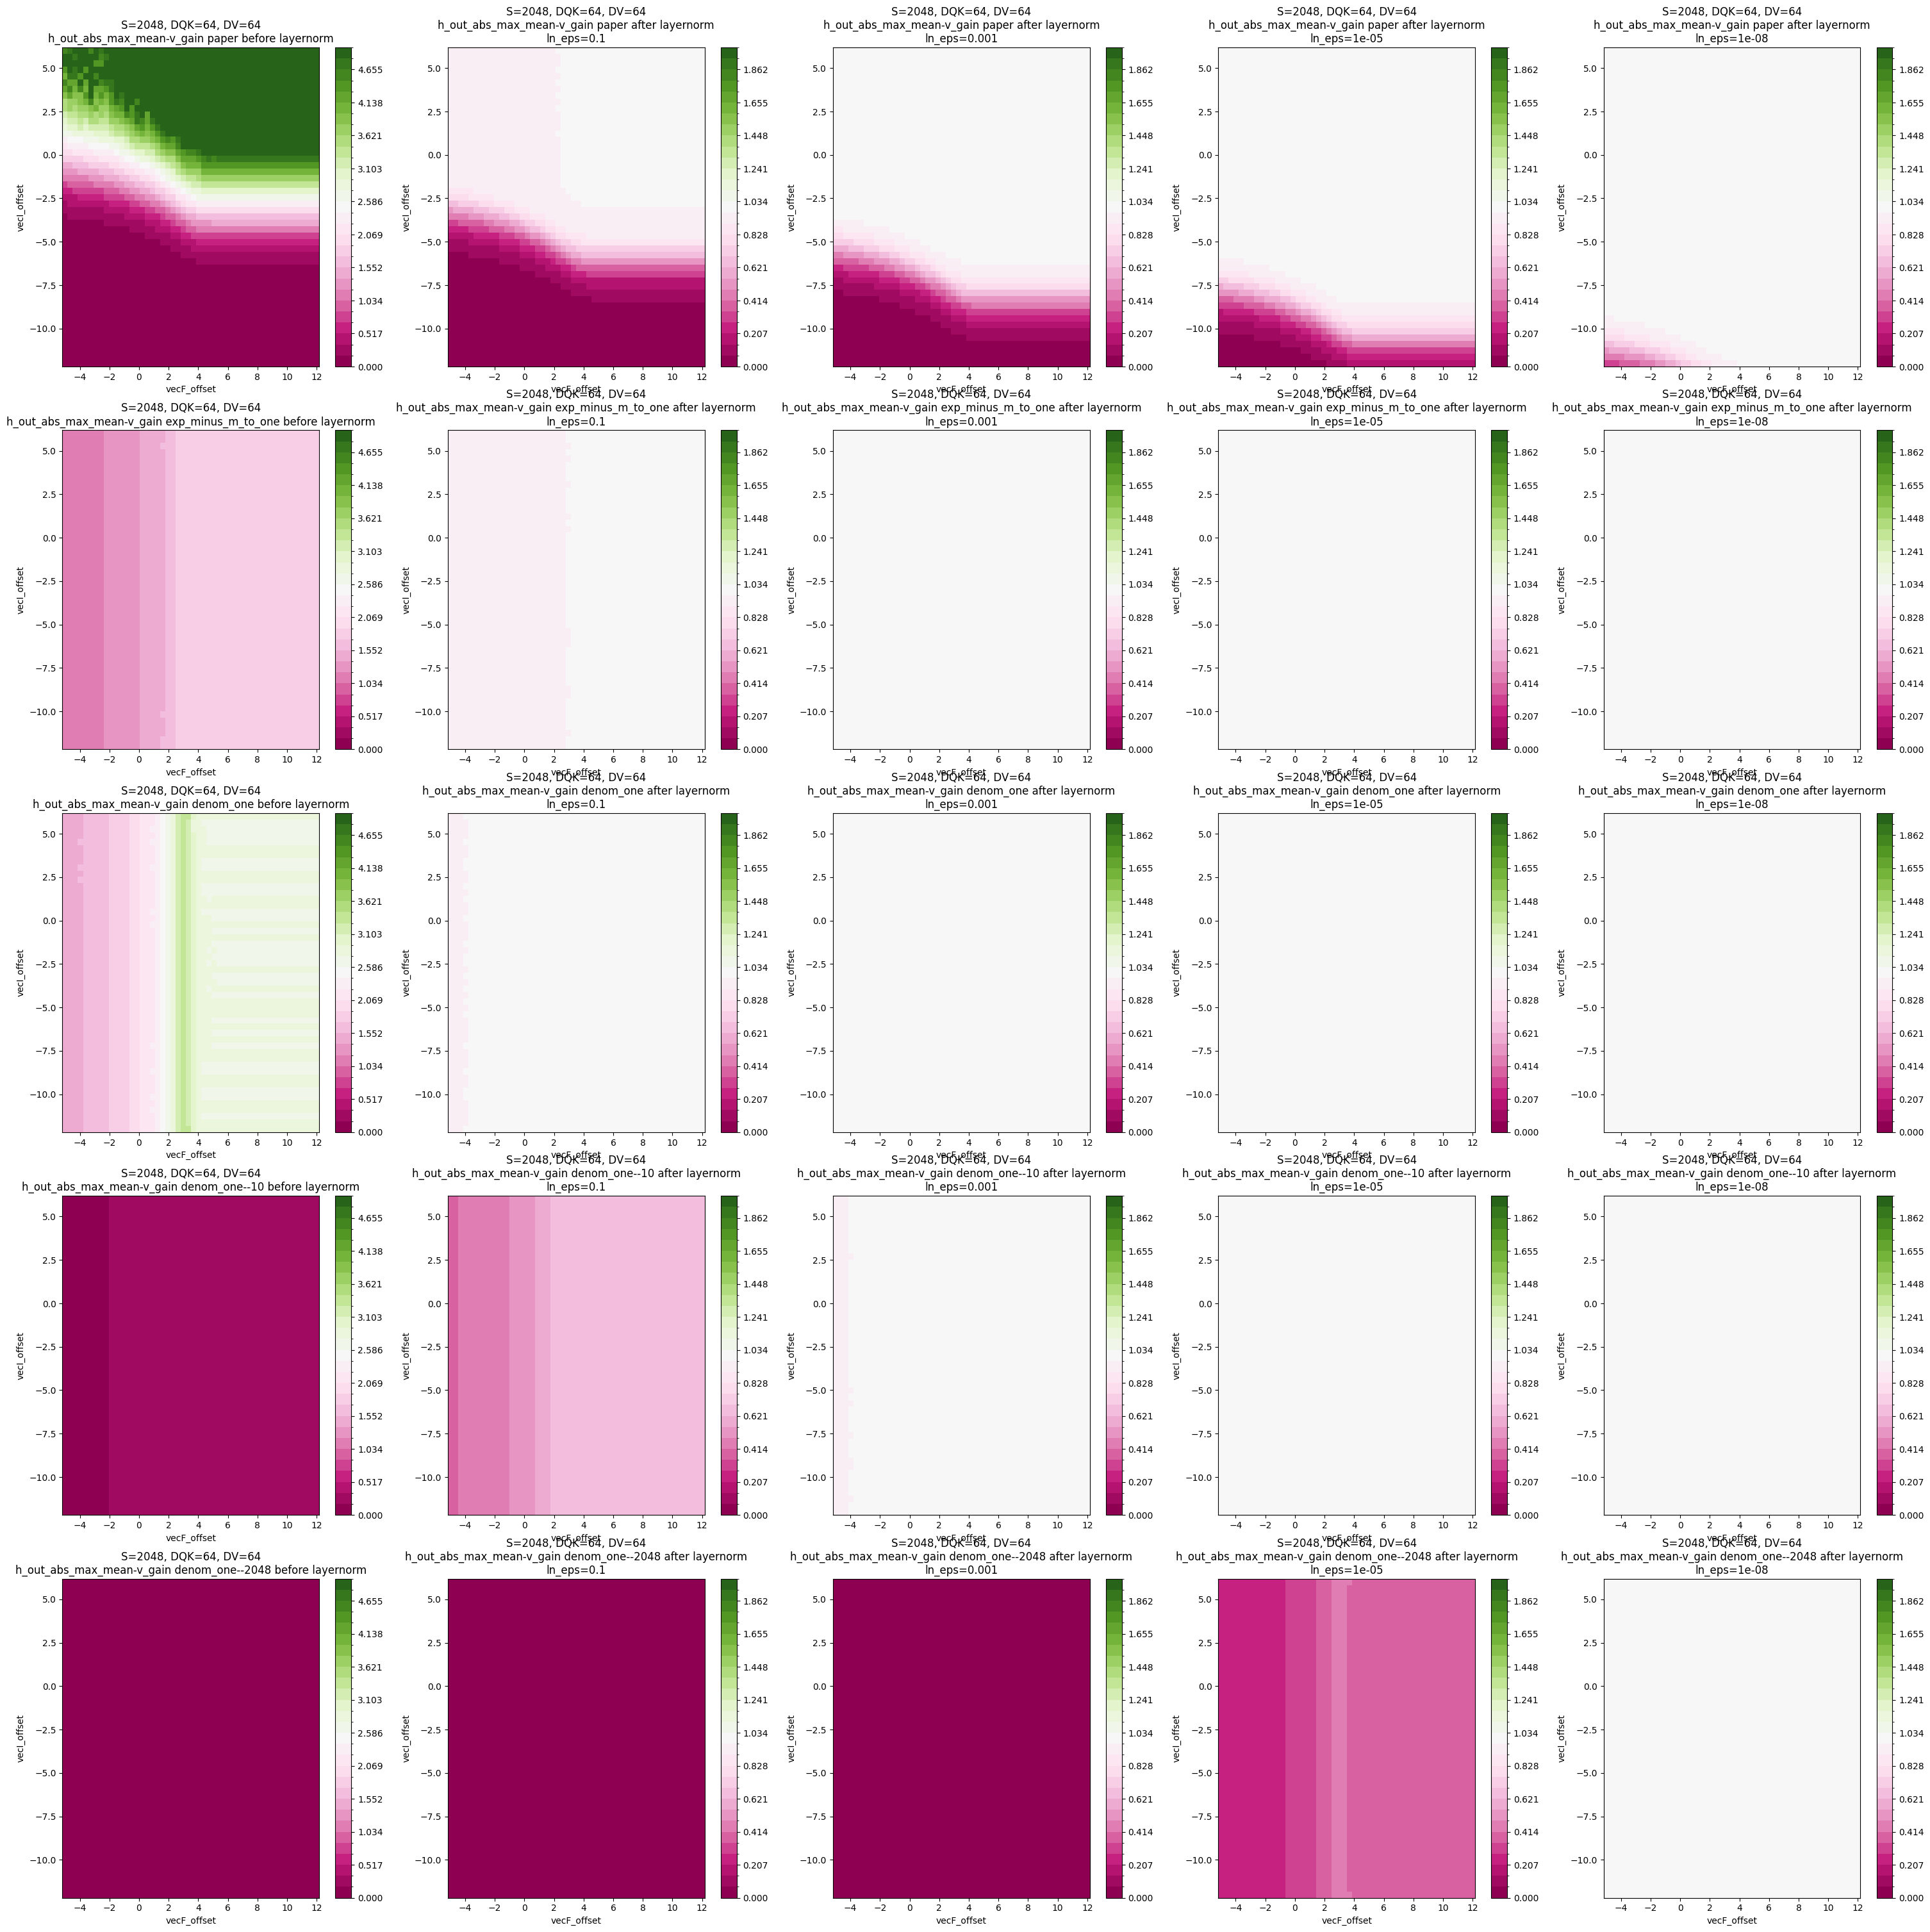

In [9]:
# abs max

S = 2048
DQK = 64  # 1024
DV = 64  # 1024
DEVICE = torch.device("cuda")
DTYPE = torch.bfloat16
vecI_offset_range = torch.linspace(-12, 6, 50)
vecF_offset_range = torch.linspace(-5, 12, 50)
levels_before_ln = np.linspace(0, 5, 30)
levels_after_ln = np.linspace(0, 2, 30)
in_stds = [1.0]  # [0.25, 0.5, 1.0]
ln_epss = [1e-1, 1e-3, 1e-5, 1e-8]  # , 1e-10]
norm_type = "rms"
denom_const_vals = [10, 2048]

taus = [5, 16, 60]
figs = []
for std in in_stds:
    for tau in taus:
        fig = make_offset_sweep_meshplot_grid(
            mlstm_func=partial(mlstm_stable_fgate_gla, tau=tau),
            seq_len=S,
            dqk=DQK,
            dv=DV,
            device=DEVICE,
            dtype=DTYPE,
            vecI_offset_range=vecI_offset_range,
            vecF_offset_range=vecF_offset_range,
            q_std=std,
            k_std=std,
            v_std=std,
            levels_before_ln=levels_before_ln,
            levels_after_ln=levels_after_ln,
            norm_eps=ln_epss,
            denom_const_vals=denom_const_vals,
            metric="h_out_abs_max_mean-v_gain",
            norm_type=norm_type,
        )
        figs.append(fig)

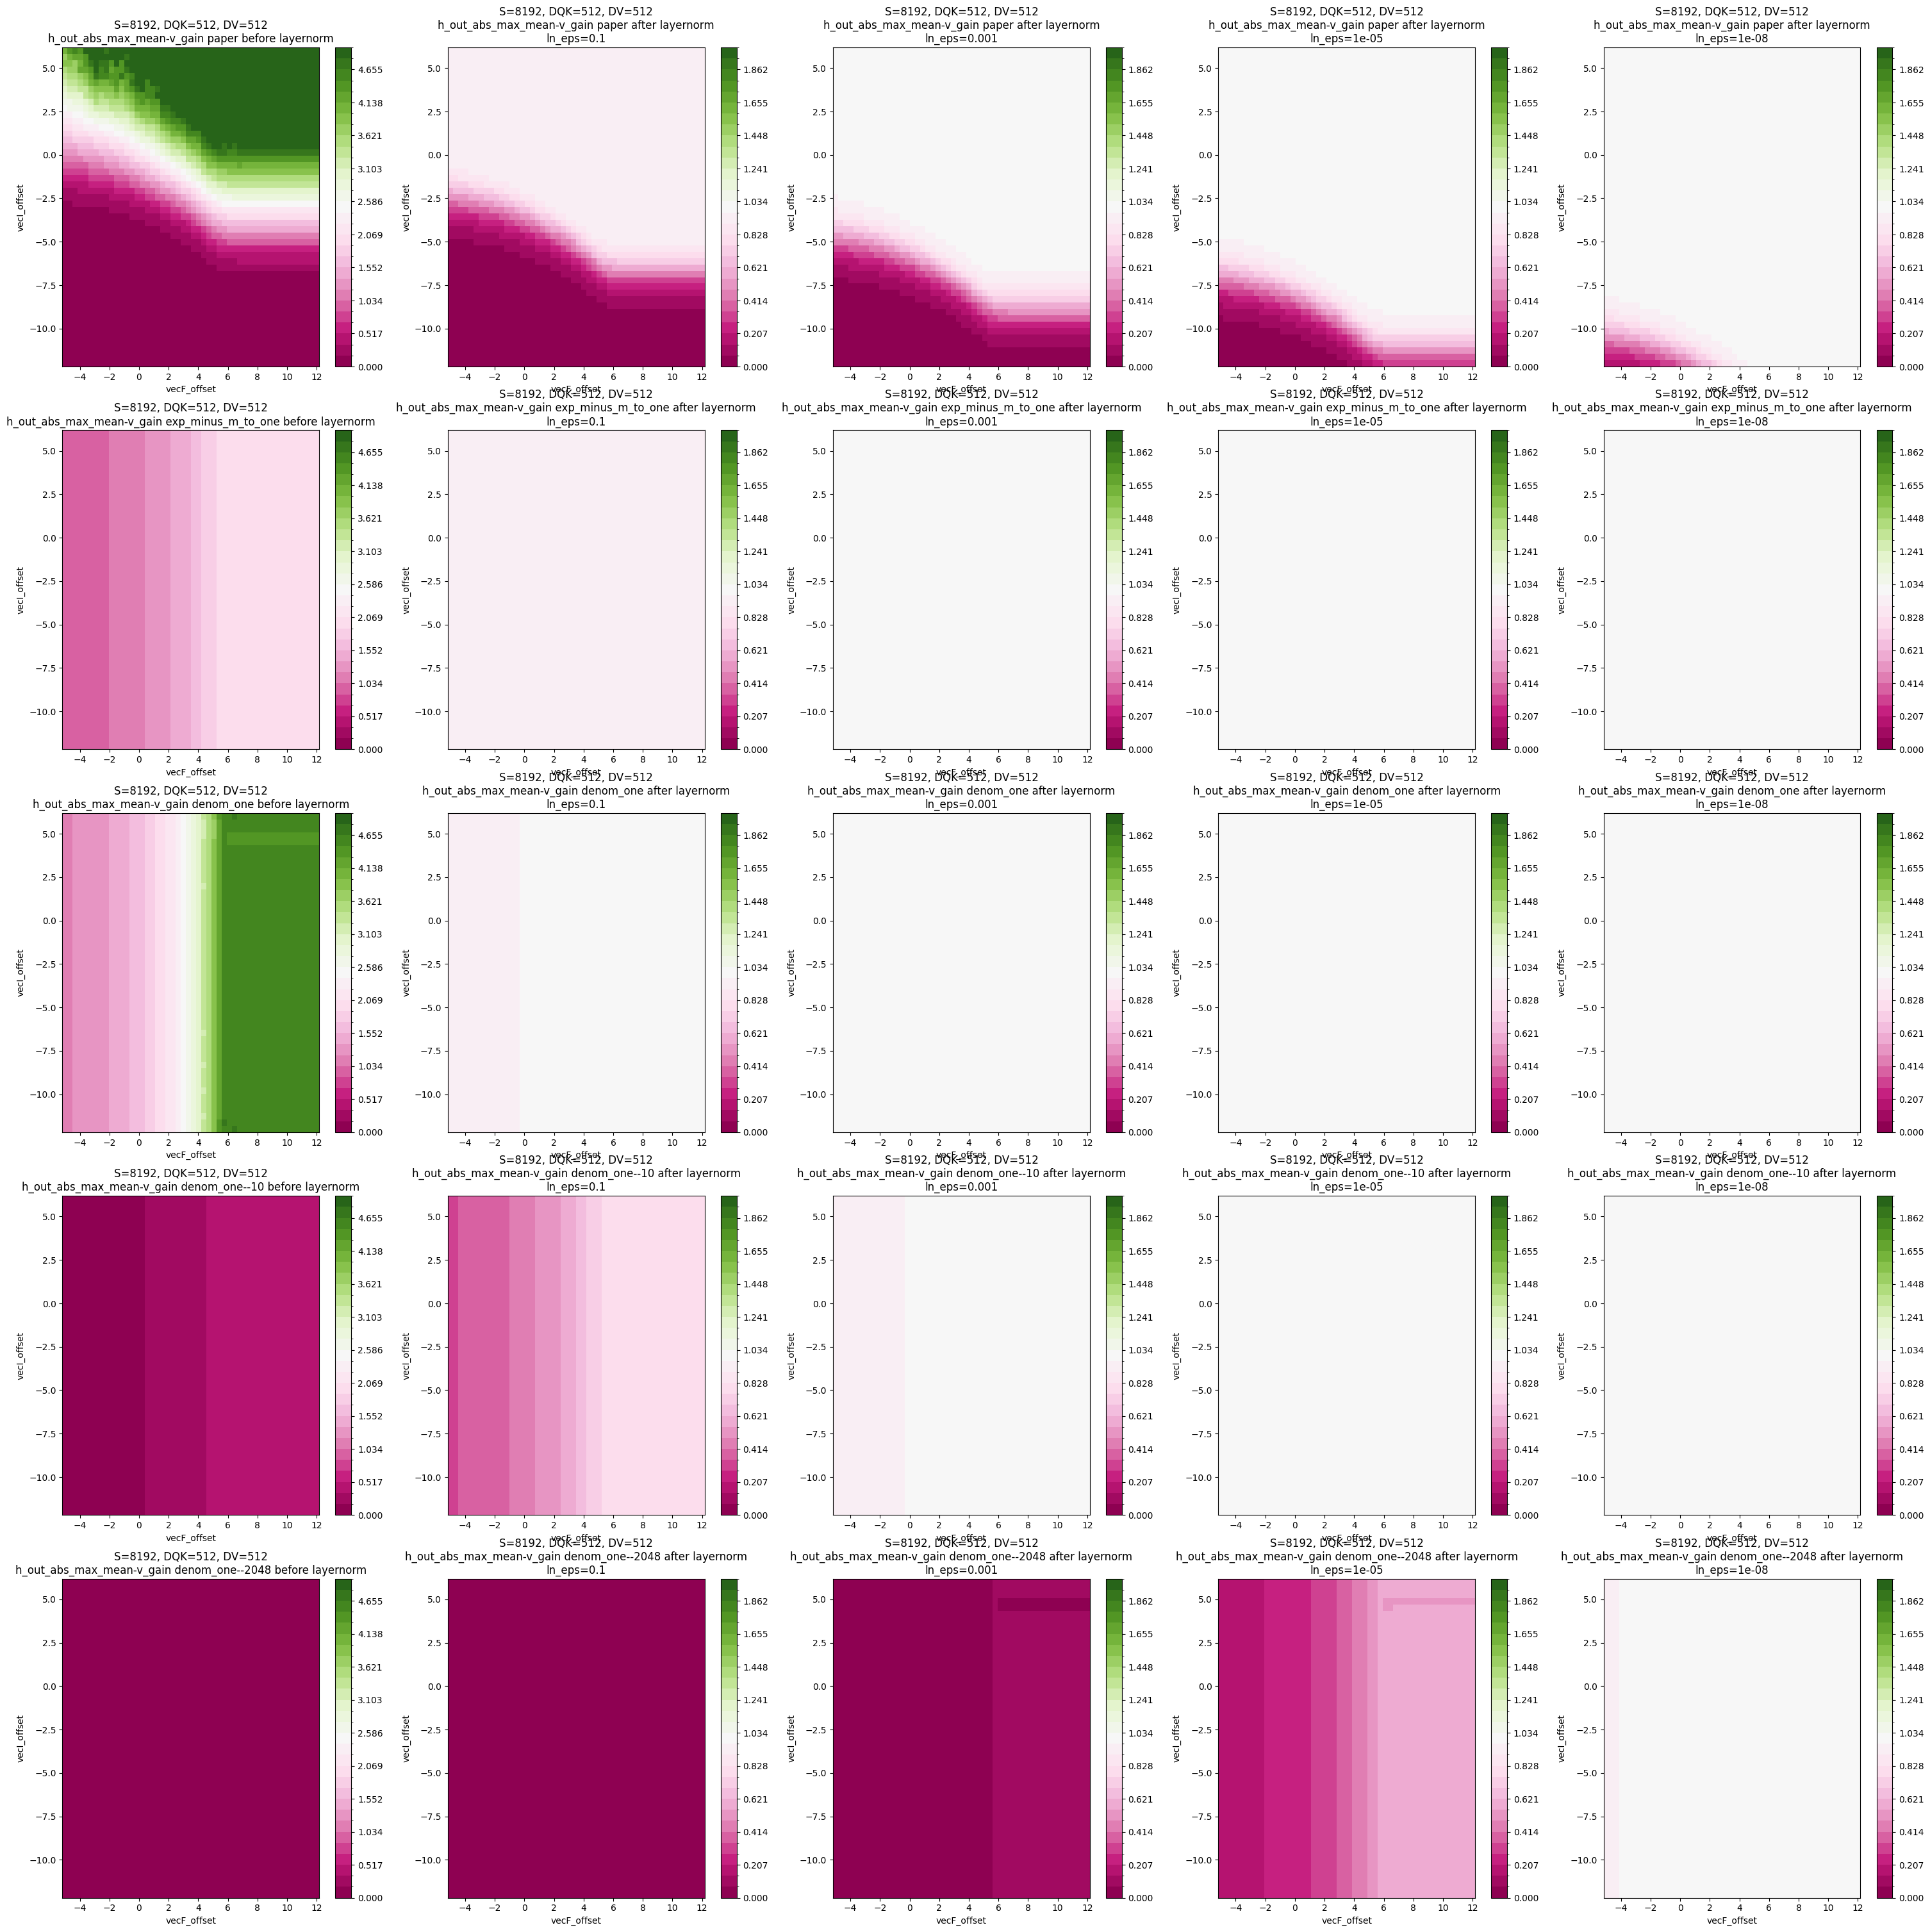

In [10]:
# abs max

S = 8192
DQK = 512  # 1024
DV = 512  # 1024
DEVICE = torch.device("cuda")
DTYPE = torch.bfloat16
vecI_offset_range = torch.linspace(-12, 6, 50)
vecF_offset_range = torch.linspace(-5, 12, 50)
levels_before_ln = np.linspace(0, 5, 30)
levels_after_ln = np.linspace(0, 2, 30)
in_stds = [1.0]  # [0.25, 0.5, 1.0]
ln_epss = [1e-1, 1e-3, 1e-5, 1e-8]  # , 1e-10]
norm_type = "rms"
denom_const_vals = [10, 2048]

taus = [16]
figs = []
for std in in_stds:
    for tau in taus:
        fig = make_offset_sweep_meshplot_grid(
            mlstm_func=partial(mlstm_stable_fgate_gla, tau=tau),
            seq_len=S,
            dqk=DQK,
            dv=DV,
            device=DEVICE,
            dtype=DTYPE,
            vecI_offset_range=vecI_offset_range,
            vecF_offset_range=vecF_offset_range,
            q_std=std,
            k_std=std,
            v_std=std,
            levels_before_ln=levels_before_ln,
            levels_after_ln=levels_after_ln,
            norm_eps=ln_epss,
            denom_const_vals=denom_const_vals,
            metric="h_out_abs_max_mean-v_gain",
            norm_type=norm_type,
        )
        figs.append(fig)

## older plots

In [ ]:
S = 4096
DQK = 1024  # 1024
DV = 1024  # 1024
DEVICE = torch.device("cuda")
DTYPE = torch.bfloat16
vecI_offset_range = torch.linspace(-12, 6, 50)
vecF_offset_range = torch.linspace(-5, 12, 50)
levels_before_ln = np.linspace(0, 10, 30)
levels_after_ln = np.linspace(0, 4, 30)
in_stds = [1.0]  # [0.25, 0.5, 1.0]
ln_epss = [1e-5, 1e-6, 1e-8, 1e-10]
denom_const_vals = [10, 2048]
figs = []
for std in in_stds:
    fig = make_offset_sweep_meshplot_grid(
        mlstm_func=mlstm_paper_unstable_fgate,
        seq_len=S,
        dqk=DQK,
        dv=DV,
        device=DEVICE,
        dtype=DTYPE,
        vecI_offset_range=vecI_offset_range,
        vecF_offset_range=vecF_offset_range,
        q_std=std,
        k_std=std,
        v_std=std,
        levels_before_ln=levels_before_ln,
        levels_after_ln=levels_after_ln,
        layernorm_eps=ln_epss,
        denom_const_vals=denom_const_vals,
    )
    figs.append(fig)

### float32

In [ ]:
S = 2048
DQK = 64  # 1024
DV = 64  # 1024
DEVICE = torch.device("cuda")
DTYPE = torch.float32
vecI_offset_range = torch.linspace(-12, 6, 50)
vecF_offset_range = torch.linspace(-5, 12, 50)
levels_before_ln = np.linspace(0, 10, 30)
levels_after_ln = np.linspace(0, 4, 30)
in_stds = [1.0]  # [0.25, 0.5, 1.0]
ln_epss = [1e-5, 1e-6, 1e-8, 1e-10]
figs = []
for std in in_stds:
    fig = make_offset_sweep_meshplot_grid(
        mlstm_func=mlstm_paper_unstable_fgate,
        seq_len=S,
        dqk=DQK,
        dv=DV,
        device=DEVICE,
        dtype=DTYPE,
        vecI_offset_range=vecI_offset_range,
        vecF_offset_range=vecF_offset_range,
        q_std=std,
        k_std=std,
        v_std=std,
        levels_before_ln=levels_before_ln,
        levels_after_ln=levels_after_ln,
        layernorm_eps=ln_epss,
    )
    figs.append(fig)

In [ ]:
# for i, f in enumerate(figs):
#     f.savefig(f"offset_sweep_unstable_fgate_std_{in_stds[i]}.pdf", bbox_inches="tight")

# for i, f in enumerate(figs):
#     print(f"offset_sweep_unstable_fgate_std_{in_stds[i]}.pdf")

In [ ]:
S = 2048
DQK = 1024
DV = 1024
DEVICE = torch.device("cuda")
DTYPE = torch.bfloat16
mh_layernorm = MultiHeadLayerNorm(ndim=1 * DV, eps=1e-6).to(device=DEVICE, dtype=DTYPE)
vecI_offset_range = torch.linspace(-8, 6, 50)
vecF_offset_range = torch.linspace(-5, 12, 50)
levels = np.linspace(0, 10, 30)
fig, axes = plt.subplots(3, 2, figsize=(30, 20))
mlstm_func = mlstm_paper_unstable_fgate
all_std = 0.6
q_std = all_std
k_std = all_std
v_std = all_std

fig = make_offset_sweep_meshplot(
    mlstm_func=partial(mlstm_func, mstate_mode="paper"),
    seq_len=S,
    dqk=DQK,
    dv=DV,
    vecI_offset_range=vecI_offset_range,
    vecF_offset_range=vecF_offset_range,
    dtype=DTYPE,
    device=DEVICE,
    ax=axes[0, 0],
    q_std=q_std,
    k_std=k_std,
    v_std=v_std,
    levels=levels,
    title_suffix="paper before layernorm",
)
fig = make_offset_sweep_meshplot(
    mlstm_func=partial(mlstm_func, mstate_mode="exp_minus_m_to_one"),
    seq_len=S,
    dqk=DQK,
    dv=DV,
    vecI_offset_range=vecI_offset_range,
    vecF_offset_range=vecF_offset_range,
    dtype=DTYPE,
    device=DEVICE,
    ax=axes[1, 0],
    levels=levels,
    q_std=q_std,
    k_std=k_std,
    v_std=v_std,
    title_suffix="exp_minus_m_to_one before layernorm",
)
fig = make_offset_sweep_meshplot(
    mlstm_func=partial(mlstm_func, mstate_mode="denom_one"),
    seq_len=S,
    dqk=DQK,
    dv=DV,
    vecI_offset_range=vecI_offset_range,
    vecF_offset_range=vecF_offset_range,
    dtype=DTYPE,
    device=DEVICE,
    ax=axes[2, 0],
    levels=levels,
    q_std=q_std,
    k_std=k_std,
    v_std=v_std,
    title_suffix="denom_one before layernorm",
)
fig = make_offset_sweep_meshplot(
    mlstm_func=partial(mlstm_func, mstate_mode="paper", mh_layernorm=mh_layernorm),
    seq_len=S,
    dqk=DQK,
    dv=DV,
    vecI_offset_range=vecI_offset_range,
    vecF_offset_range=vecF_offset_range,
    dtype=DTYPE,
    device=DEVICE,
    ax=axes[0, 1],
    levels=levels,
    q_std=q_std,
    k_std=k_std,
    v_std=v_std,
    title_suffix="paper after layernorm",
)
fig = make_offset_sweep_meshplot(
    mlstm_func=partial(
        mlstm_func,
        mstate_mode="exp_minus_m_to_one",
        mh_layernorm=mh_layernorm,
    ),
    seq_len=S,
    dqk=DQK,
    dv=DV,
    vecI_offset_range=vecI_offset_range,
    vecF_offset_range=vecF_offset_range,
    dtype=DTYPE,
    device=DEVICE,
    ax=axes[1, 1],
    levels=levels,
    q_std=q_std,
    k_std=k_std,
    v_std=v_std,
    title_suffix="exp_minus_m_to_one after layernorm",
)
fig = make_offset_sweep_meshplot(
    mlstm_func=partial(mlstm_func, mstate_mode="denom_one", mh_layernorm=mh_layernorm),
    seq_len=S,
    dqk=DQK,
    dv=DV,
    vecI_offset_range=vecI_offset_range,
    vecF_offset_range=vecF_offset_range,
    dtype=DTYPE,
    device=DEVICE,
    ax=axes[2, 1],
    levels=levels,
    q_std=q_std,
    k_std=k_std,
    v_std=v_std,
    title_suffix="denom_one after layernorm",
)

## Single offset sweep plots.

In [ ]:
vecI_offset_range = torch.linspace(-8, 6, 50)
vecF_offset_range = torch.linspace(-5, 12, 50)
fig = make_offset_sweep_meshplot(
    mlstm_func=partial(mlstm_paper_unstable_fgate, mstate_mode="paper"),
    seq_len=2048,
    dqk=1024,
    dv=1024,
    vecI_offset_range=vecI_offset_range,
    vecF_offset_range=vecF_offset_range,
    dtype=torch.float64,
    device=torch.device("cuda"),
)

In [ ]:
vecI_offset_range = torch.linspace(-8, 6, 50)
vecF_offset_range = torch.linspace(-5, 12, 50)
fig = make_offset_sweep_meshplot(
    mlstm_func=partial(mlstm_paper_unstable_fgate, mstate_mode="paper"),
    seq_len=2048,
    dqk=1024,
    dv=1024,
    vecI_offset_range=vecI_offset_range,
    vecF_offset_range=vecF_offset_range,
    dtype=torch.float32,
    device=torch.device("cuda"),
    levels=np.linspace(0, 10, 30),
)

In [ ]:
vecI_offset_range = torch.linspace(-8, 6, 50)
vecF_offset_range = torch.linspace(-5, 12, 50)
fig = make_offset_sweep_meshplot(
    mlstm_func=partial(mlstm_paper_unstable_fgate, mstate_mode="exp_minus_m_to_one"),
    seq_len=2048,
    dqk=1024,
    dv=1024,
    vecI_offset_range=vecI_offset_range,
    vecF_offset_range=vecF_offset_range,
    dtype=torch.float32,
    levels=np.linspace(0, 10, 30),
    device=torch.device("cuda"),
)

In [ ]:
vecI_offset_range = torch.linspace(-8, 6, 50)
vecF_offset_range = torch.linspace(-5, 12, 50)
fig = make_offset_sweep_meshplot(
    mlstm_func=partial(mlstm_paper_unstable_fgate, mstate_mode="denom_one"),
    seq_len=2048,
    dqk=1024,
    dv=1024,
    vecI_offset_range=vecI_offset_range,
    vecF_offset_range=vecF_offset_range,
    dtype=torch.float32,
    levels=np.linspace(0, 10, 30),
    device=torch.device("cuda"),
)

In [ ]:
vecI_offset_range = torch.linspace(-8, 6, 50)
vecF_offset_range = torch.linspace(-5, 12, 50)
fig = make_offset_sweep_meshplot(
    mlstm_func=partial(mlstm_paper_unstable_fgate, mstate_mode="sum_only"),
    seq_len=2048,
    dqk=1024,
    dv=1024,
    vecI_offset_range=vecI_offset_range,
    vecF_offset_range=vecF_offset_range,
    dtype=torch.float32,
    device=torch.device("cuda"),
)

In [ ]:
vecI_offset_range = torch.linspace(-8, 6, 50)
vecF_offset_range = torch.linspace(-5, 12, 50)
fig = make_offset_sweep_meshplot(
    mlstm_func=mlstm_chunkwise_max_triton_v3,
    seq_len=8192,
    dqk=1024,
    dv=1024,
    vecI_offset_range=vecI_offset_range,
    vecF_offset_range=vecF_offset_range,
    dtype=torch.bfloat16,
    device=torch.device("cuda"),
)

In [ ]:
vecI_offset_range = torch.linspace(-8, 6, 50)
vecF_offset_range = torch.linspace(-5, 12, 50)
levels_before_ln = np.linspace(0, 10, 30)
levels_after_ln = np.linspace(0, 4, 30)
fig = make_offset_sweep_meshplot(
    mlstm_func=partial(mlstm_chunkwise_triton_kernel, eps=1e-6),
    seq_len=8192,
    dqk=1024,
    dv=1024,
    vecI_offset_range=vecI_offset_range,
    vecF_offset_range=vecF_offset_range,
    dtype=torch.bfloat16,
    device=torch.device("cuda"),
    levels=levels_before_ln,
)

In [ ]:
vecI_offset_range = torch.linspace(-8, 6, 50)
vecF_offset_range = torch.linspace(-5, 12, 50)
levels_before_ln = np.linspace(0, 10, 30)
levels_after_ln = np.linspace(0, 4, 30)
fig = make_offset_sweep_meshplot(
    mlstm_func=partial(mlstm_chunkwise_triton_kernel, eps=0.0),
    seq_len=8192,
    dqk=1024,
    dv=1024,
    vecI_offset_range=vecI_offset_range,
    vecF_offset_range=vecF_offset_range,
    dtype=torch.bfloat16,
    device=torch.device("cuda"),
    levels=levels_before_ln,
)

In [ ]:
vecI_offset_range = torch.linspace(-8, 6, 50)
vecF_offset_range = torch.linspace(-5, 12, 50)
levels_before_ln = np.linspace(0, 10, 30)
levels_after_ln = np.linspace(0, 4, 30)
fig = make_offset_sweep_meshplot(
    mlstm_func=partial(mlstm_chunkwise_triton_kernel, eps=1e-1),
    seq_len=8192,
    dqk=1024,
    dv=1024,
    vecI_offset_range=vecI_offset_range,
    vecF_offset_range=vecF_offset_range,
    dtype=torch.bfloat16,
    device=torch.device("cuda"),
    levels=levels_before_ln,
)

In [ ]:
vecI_offset_range = torch.linspace(-8, 6, 50)
vecF_offset_range = torch.linspace(-5, 12, 50)
levels_before_ln = np.linspace(0, 10, 30)
levels_after_ln = np.linspace(0, 4, 30)
fig = make_offset_sweep_meshplot(
    mlstm_func=partial(mlstm_chunkwise_triton_kernel, eps=1e1),
    seq_len=8192,
    dqk=1024,
    dv=1024,
    vecI_offset_range=vecI_offset_range,
    vecF_offset_range=vecF_offset_range,
    dtype=torch.bfloat16,
    device=torch.device("cuda"),
    levels=levels_before_ln,
)

In [ ]:
mh_layernorm = MultiHeadLayerNorm(ndim=1 * 1024, eps=1e-5).to(device=DEVICE, dtype=DTYPE)
fig = make_offset_sweep_meshplot(
    mlstm_func=partial(mlstm_chunkwise_triton_kernel, mh_layernorm=mh_layernorm),
    seq_len=8192,
    dqk=1024,
    dv=1024,
    vecI_offset_range=vecI_offset_range,
    vecF_offset_range=vecF_offset_range,
    dtype=torch.bfloat16,
    device=torch.device("cuda"),
    levels=levels_after_ln,
)

In [ ]:
mh_layernorm = MultiHeadLayerNorm(ndim=1 * 1024, eps=1e-5).to(device=DEVICE, dtype=DTYPE)
fig = make_offset_sweep_meshplot(
    mlstm_func=partial(mlstm_chunkwise_triton_kernel, mh_layernorm=mh_layernorm),
    seq_len=2048,
    dqk=1024,
    dv=1024,
    vecI_offset_range=vecI_offset_range,
    vecF_offset_range=vecF_offset_range,
    dtype=torch.bfloat16,
    device=torch.device("cuda"),
    levels=levels_after_ln,
)

In [ ]:
vecI_offset_range = torch.linspace(-8, 6, 50)
vecF_offset_range = torch.linspace(-5, 12, 50)
fig = make_offset_sweep_meshplot(
    mlstm_func=mlstm_chunkwise_max_triton_v3,
    seq_len=8192,
    dqk=512,
    dv=512,
    vecI_offset_range=vecI_offset_range,
    vecF_offset_range=vecF_offset_range,
    dtype=torch.bfloat16,
    device=torch.device("cuda"),
)

In [ ]:
torch.std(0.1 * torch.randn((10000,)))

In [ ]:
vecI_offset_range = torch.linspace(-8, 6, 50)
vecF_offset_range = torch.linspace(-5, 12, 50)
fig = make_offset_sweep_meshplot(
    mlstm_func=mlstm_chunkwise_max_triton_v3,
    seq_len=2048,
    dqk=1024,
    dv=1024,
    q_std=0.5,
    k_std=0.5,
    v_std=0.5,
    vecI_offset_range=vecI_offset_range,
    vecF_offset_range=vecF_offset_range,
    levels=np.linspace(0, 15, 30),
    dtype=torch.bfloat16,
    device=torch.device("cuda"),
)